# Inspect all installed turbines in Denmark
Authors: Karen Pardos Olsen, DTU Elektro <br>
Date: Nov 20 2018 <br>
Mapping requires: python packages basemap, pyproj, utm

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import windpype as wp
fs = 15
mpl.rcParams['xtick.labelsize'] = fs
mpl.rcParams['axes.labelweight'] = 500
mpl.rcParams['ytick.labelsize'] = fs
mpl.rcParams['axes.labelsize']=fs

windpype submodule "power" imported
windpype submodule "aux" imported
windpype submodule "capacity" imported
windpype module import complete


## Capacity info

In [2]:
file_path = "data/"
power_ob = wp.CombPowerData(file_path=file_path,file_name='DK1_DK2_power_cons_1hour')
time_cut = [np.datetime64('2011-01-01'),np.datetime64('2018-11-01')]
capacity_ob = wp.Capacity(file_path=file_path+'Energistyrelsen/',file_name='capacity_df')
capacity_ob.AddData(file_path=file_path+'Energistyrelsen/')

No method set for combining, will look for passed dataframe
No dataframe given, will look for saved file
Restored dataframe


Total capacity in DK: 5717.454000000308 MW
len of capacity arrays: 1153434
DK takes up:
100.00 % to 100.00 % 
DK1 takes up:
74.44 % to 79.76 % 
DK2 takes up:
20.45 % to 25.51 % 
BO takes up:
0.62 % to 0.80 % 


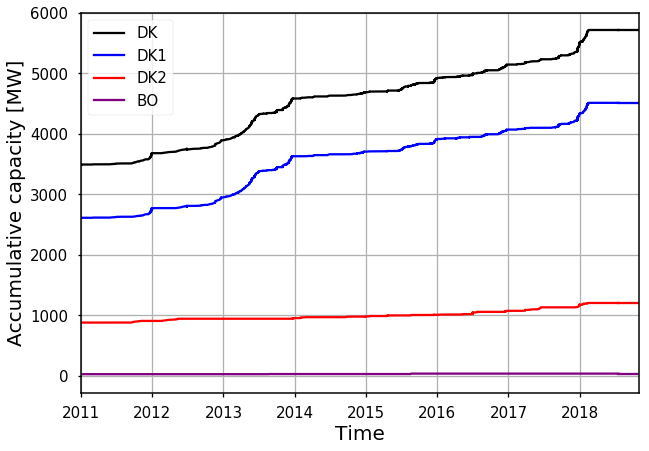

In [3]:
capacity_ob.PlotCapacity(time_cut=time_cut,fig_name='capacity_DK',fig_format='png')

## Map positions

In [ ]:
from mpl_toolkits.basemap import pyproj
from mpl_toolkits.basemap import Basemap
import utm as utm

In [ ]:
# Load turbine positions
file_path = "../../data/ENS/"
Xcoord = pd.read_table(file_path+'Xcoord.txt',skiprows=1,names=['Xcoord'],engine='python',skip_blank_lines=False)
Ycoord = pd.read_table(file_path+'Ycoord.txt',skiprows=1,names=['Ycoord'],engine='python',skip_blank_lines=False)
capacity = pd.read_table(file_path+'Kapacitet.txt',skiprows=1,names=['capacity'],engine='python',skip_blank_lines=False)
communenr = pd.read_table(file_path+'Kommune-nr.txt',skiprows=1,names=['communenr'],engine='python')
# Combine into one dataframe
data_df = pd.concat([capacity,Xcoord,Ycoord,communenr],axis=1)

In [ ]:
# Convert coordinates from UTM 32 to latitude and longitude
# utm.to_latlon takes EASTING, NORTHING, ZONE NUMBER, ZONE LETTER
lat, lon = np.zeros(len(data_df)),np.zeros(len(data_df))
for _ in range(len(data_df)):
    try:
        lat[_],lon[_] = utm.to_latlon(data_df['Xcoord'][_],data_df['Ycoord'][_], 32, 'U')
    except:
        lat[_],lon[_] = 0,0
data_df['lat'] = lat
data_df['lon'] = lon
# Remove any rows with missing coordinates or missing "kommune nr"
mask = np.array([(data_df['lat'] != 0) & (data_df['communenr'] != 0)])[0]
data_df = data_df[mask].reset_index(drop=True)
print('%s turbines placements found!' % len(data_df))

In [ ]:
# Split into dataframes of different regions
data_df_DK1 = data_df[data_df['communenr'] > 400].copy().reset_index(drop=True)
data_df_DK2 = data_df[data_df['communenr'] <= 400].copy().reset_index(drop=True)
data_df_BO = data_df[data_df['communenr'] == 400].copy().reset_index(drop=True)
# Put into dictionary
data_df_dict = dict(DK=data_df,DK1=data_df_DK1,DK2=data_df_DK2,BO=data_df_BO)

In [ ]:
# Find center position, weighted by capacity and max distance from weighted center in each region
mean_r,max_r,centers_lat,centers_lon = {},{},{},{}
for key in data_df_dict.keys():
    df = data_df_dict[key]
    center_x,center_y = np.sum(df['Xcoord'].values*df['capacity'].values)/np.sum(df['capacity'].values),np.sum(df['Ycoord'].values*df['capacity'].values)/np.sum(df['capacity'].values)
    centers_lat[key],centers_lon[key] = utm.to_latlon(center_x,center_y, 32, 'U')
    mean_r[key] = np.mean(np.sqrt((df['Xcoord'].values-center_x)**2 + (df['Ycoord'].values-center_y)**2))
    max_r[key] = np.max(np.sqrt((df['Xcoord'].values-center_x)**2 + (df['Ycoord'].values-center_y)**2))
# Convert to numpy arrays
# mean_r,max_r,centers_lat,centers_lon = np.array(mean_r),np.array(max_r),np.array(centers_lat),np.array(centers_lon)
print('Radii of regions in km')
print('Region\tMean\tMax')
text = [print('%s:\t%.2f\t%.2f' % (key,mean_r[key]/1000.,max_r[key]/1000.)) for key in data_df_dict.keys()]

In [ ]:
# Set up function that plots a circle
def plot_circle(m,r_km,center,color):
    
    lons, lats, xs, ys = m.makegrid(200, 200, returnxy=True)

    gc = pyproj.Geod(a=m.rmajor, b=m.rminor)

    distances = np.zeros(lons.size)

    for k, (lo, la) in enumerate(zip(lons.flatten(), lats.flatten())):
        _, _, distances[k] = gc.inv(center[0], center[1], lo, la)

    distances = distances.reshape(200, 200)  # In km.

    # Plot perimeters of equal distance.
    levels = [r_km]  # [50, 100, 150]
    cs = m.contour(xs, ys, distances, levels, colors=color)

In [ ]:
fig, ax = plt.subplots(figsize=(15, 15))

# BASEMAP OPTIONS
m = Basemap(llcrnrlon=7,llcrnrlat=54,urcrnrlon=16.5,urcrnrlat=58,
            resolution='i',projection='tmerc',lon_0=9.5,lat_0=56, epsg=5520)
m.drawcoastlines()
# Fill continents with plain color:
# m.fillcontinents(color='navajowhite',lake_color='lightcyan')
# m.drawmapboundary(fill_color='lightcyan')
# Fill continents with 2D imagery:
m.arcgisimage(service =  'ESRI_Imagery_World_2D', xpixels = 2000, alpha=0.05)
# Indicate country borders and rivers:
m.drawcountries(color='white', linewidth=1)
# m.drawrivers(linewidth=0.5,color="blue")
# Draw parallels and meridians, labels = [left,right,top,bottom]:
m.drawparallels(np.arange(30,61.,1.),labels=[True,True,False,False], fontsize=15)
m.drawmeridians(np.arange(0.,21.,1.),labels=[False,False,True,True], fontsize=15)

# Plot positions of turbines
colors = dict(DK='k',DK1='magenta',DK2='royalblue',BO='cyan')
for key in data_df_dict.keys():
    mlon,mlat = m(data_df_dict[key]['lon'].values,data_df_dict[key]['lat'].values)
    m.plot(mlon,mlat, '.',color=colors[key], ms=2, label=key)

# Plot center positions and radii for each region
for key in data_df_dict.keys():
    center_mlon,center_mlat = m(centers_lon[key],centers_lat[key])
    m.plot(center_mlon,center_mlat, 'x', color=colors[key], ms=15, mew=3)
    plot_circle(m,mean_r[key],[centers_lon[key],centers_lat[key]],colors[key])


lgnd = plt.legend(loc='upper right',fontsize=15)
[lgnd.legendHandles[_]._legmarker.set_markersize(8) for _ in range(len(lgnd.legendHandles))]

plt.savefig('../../plots/turbine_placement_mean_r.pdf',format='pdf',dpi=300)
plt.savefig('../../plots/turbine_placement_mean_r.png',format='png',dpi=300)